# Caml API Usage

In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

datasets = [
    "partially_linear_simple",
    "fully_heterogenous",
    "partially_linear_constant",
    "dowhy_linear",
]
backends = ["pandas", "pyspark", "polars"]

df_backend = backends[0]
dataset = datasets[3]

## Synthetic Data

In [271]:
from caml.extensions.synthetic_data import (
    make_partially_linear_dataset_simple,
    make_fully_heterogeneous_dataset,
    make_partially_linear_dataset_constant,
    make_dowhy_linear_dataset,
)

if dataset == "partially_linear_simple":
    df, true_cates, true_ate = make_partially_linear_dataset_simple(
        n_obs=5000,
        n_confounders=5,
        dim_heterogeneity=2,
        binary_treatment=True,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "fully_heterogenous":
    df, true_cates, true_ate = make_fully_heterogeneous_dataset(
        n_obs=10_000,
        n_confounders=10,
        theta=4.0,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "partially_linear_constant":
    df, true_cates, true_ate = make_partially_linear_dataset_constant(
        n_obs=5000,
        ate=4.0,
        n_confounders=5,
        dgp="make_plr_CCDDHNR2018",  # make_plr_turrell2018
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "dowhy_linear":
    df, true_cates, true_ate = make_dowhy_linear_dataset(
        beta=2.0,
        n_obs=10_000,
        n_confounders=10,
        n_discrete_confounders=3,
        n_effect_modifiers=10,
        n_discrete_effect_modifiers=3,
        n_treatments=1,
        binary_treatment=True,
        categorical_treatment=False,
        binary_outcome=False,
        seed=12,
    )

    for i in range(1, len(true_cates) + 1):
        if isinstance(true_cates[f"d{i}"], list):
            df[f"true_cate_d{i}_1"] = true_cates[f"d{i}"][0]
            df[f"true_cate_d{i}_2"] = true_cates[f"d{i}"][1]
        else:
            df[f"true_cate_d{i}"] = true_cates[f"d{i}"]


df["uuid"] = df.index

In [272]:
try:
    import polars as pl
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [273]:
df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W4,W5,W6,W7,W8,W9,d1,y,true_cate_d1,uuid
0,0.860128,1.263800,-1.621480,-1.243014,0.119318,0.138299,-2.190976,3,0,2,...,-1.777832,3.709313,0.203607,2,3,0,True,4.197980,0.793035,0
1,0.085828,-0.258028,0.648743,-1.045765,-0.128647,0.435518,0.108749,3,0,2,...,-2.000380,2.047290,1.303302,2,2,2,True,8.774372,5.340261,1
2,1.077397,-0.389245,0.503995,-1.182757,-1.419884,1.466198,-1.111965,3,3,2,...,-3.189385,0.190063,0.273025,1,2,1,False,-6.610495,7.983276,2
3,1.864333,0.424140,0.705238,1.087511,-0.978616,1.553906,-1.056368,1,3,0,...,-0.935434,0.159549,0.229549,1,3,2,True,8.211690,10.040109,3
4,0.042030,-2.178140,0.773407,-1.260931,0.600929,0.659652,-0.311650,0,3,0,...,-4.118267,1.372630,1.033920,3,0,3,True,3.598249,4.030683,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.173214,1.718103,0.527236,-0.833312,0.857061,-0.963238,-0.802704,0,2,2,...,1.446361,0.877547,0.160547,0,1,1,True,10.896206,6.942622,9995
9996,0.916397,0.691821,0.512401,-0.098800,-0.721480,0.789828,0.042103,2,2,2,...,-1.341384,-0.574287,2.923056,2,2,1,True,10.268397,9.750975,9996
9997,3.512478,-0.894800,1.119166,-1.482994,-1.278946,-0.029847,-0.221000,3,3,2,...,-1.698003,1.961363,0.020335,2,1,2,True,11.488667,11.082038,9997
9998,0.615903,1.969203,0.407985,0.945009,0.580888,0.783290,-1.168335,1,3,2,...,-2.156037,1.078907,1.013377,2,0,3,True,12.162188,11.152002,9998


In [274]:
from caml.extensions.synthetic_data import CamlSyntheticDataGenerator

data =  CamlSyntheticDataGenerator(n_obs=10_000,
                                  n_cont_outcomes=1,
                                  n_binary_outcomes=0,
                                  n_cont_treatments=1,
                                  n_binary_treatments=0,
                                  n_discrete_treatments=0,
                                  n_cont_confounders=2, 
                                  n_binary_confounders=2,
                                  n_discrete_confounders=2,
                                  n_cont_heterogeneity_covariates=4,
                                  n_binary_heterogeneity_covariates=4,
                                  n_discrete_heterogeneity_covariates=4,
                                  n_heterogeneity_confounders=0,
                                  stddev_outcome_noise=3,
                                  stddev_treatment_noise=3,
                                  causal_model_functional_form="fully_non_linear",
                                  n_nonlinear_transformations=10,
                                  n_nonlinear_interactions=5,
                                  treatment_effect_weight=1,
                                  seed=None)

synthetic_df = data.df
cate_df = data.cates
ate_df = data.ates
dgp = data.dgp

df = synthetic_df.copy()

df

,W1_continuous,W2_continuous,W1_binary,W2_binary,W1_discrete,W2_discrete,X1_continuous,X2_continuous,X3_continuous,X4_continuous,X1_binary,X2_binary,X3_binary,X4_binary,X1_discrete,X2_discrete,X3_discrete,X4_discrete,T1_continuous,Y1_continuous
0,0.406044,-0.151649,0,0,1,10,4.232622,0.747387,4.874727,0.726902,0,1,1,0,6,0,1,0,-19.115807,1079.464650
1,1.438724,-2.336934,1,1,1,6,0.117746,6.535678,4.143518,3.091032,0,1,1,0,8,0,1,0,-11.178740,68.928005
2,2.884024,-2.542391,1,0,1,13,5.219183,3.807166,2.748808,2.267096,0,1,0,0,8,1,1,0,-19.722470,827.325915
3,0.113439,-0.581423,1,1,1,19,5.691499,7.863248,3.874850,1.311375,1,1,1,1,7,0,2,1,-32.111036,1997.805122
4,5.112845,-2.602360,1,0,1,25,4.319512,1.853090,3.062959,4.061395,0,1,0,1,9,0,1,3,-41.549068,1706.448421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.620626,0.955814,0,1,1,45,2.212935,5.095046,4.062946,0.967618,0,1,0,0,11,0,1,4,-71.640000,1966.545754
9996,0.016592,-0.768066,0,0,2,4,0.026808,9.745895,3.225506,3.098420,0,1,0,1,7,0,2,2,-6.595926,26.114568
9997,0.322272,-2.021281,0,1,1,1,1.981227,7.759381,3.956030,5.489068,0,0,1,0,6,1,2,0,-0.000034,16.652740
9998,1.727967,-2.057457,0,0,1,6,2.102762,8.927030,4.238957,1.386538,1,1,1,0,6,0,0,0,-7.485863,229.205593


In [275]:
cate_df

,CATE_of_T1_continuous_on_Y1_continuous
0,-59.074667
1,-4.133320
2,-44.380636
3,-63.083630
4,-42.443864
...,...
9995,-27.384826
9996,-0.099239
9997,-20.968952
9998,-31.481700


In [276]:
ate_df

,Treatment,ATE
0,T1_continuous_on_Y1_continuous,-21.791433


In [277]:
dgp['Y1_continuous']

,covariates,params,transformation
0,W1_continuous,1.692535,None
1,W2_continuous,1.301720,None
2,W1_binary,-1.749237,None
3,W2_binary,-0.417859,None
4,W1_discrete,-2.600975,None
5,W2_discrete,-2.569533,None
6,X1_continuous,-2.701080,None
7,X2_continuous,1.644644,None
8,X3_continuous,2.192629,None
9,X4_continuous,0.192064,None


## Core API

### CamlCATE

#### Class Instantiation

In [278]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="Y1_continuous",
    T="T1_continuous",
    X=[c for c in df.columns if "X" in c or "W" in c],
    W=[],
    discrete_treatment=False,
    discrete_outcome=False,
    seed=10,
    verbose=1,
)

[12/16/24 19:00:43] INFO     Logging has been set up.                                                 ]8;id=615488;file:///home/jakep/projects/caml/caml/logging.py\logging.py]8;;\:]8;id=125715;file:///home/jakep/projects/caml/caml/logging.py#51\51]8;;\

                    WARNING  Validation for continuous treatments is not supported yet.                 ]8;id=258599;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=132745;file:///home/jakep/projects/caml/caml/core/cate.py#243\243]8;;\

In [279]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10,000
Outcome Variable: Y1_continuous
Discrete Outcome: False
Treatment Variable: T1_continuous
Discrete Treatment: False
Features/Confounders for Heterogeneity (X): ['W1_continuous', 'W2_continuous', 'W1_binary', 'W2_binary', 'W1_discrete', 'W2_discrete', 'X1_continuous', 'X2_continuous', 'X3_continuous', 'X4_continuous', 'X1_binary', 'X2_binary', 'X3_binary', 'X4_binary', 'X1_discrete', 'X2_discrete', 'X3_discrete', 'X4_discrete']
Features/Confounders as Controls (W): []
Random Seed: 10



#### Nuissance Function AutoML

In [280]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 60},
    flaml_T_kwargs={"time_budget": 60},
    use_ray=False,
    use_spark=False,
)

[flaml.automl.logger: 12-16 19:00:45] {1680} INFO - task = regression
[flaml.automl.logger: 12-16 19:00:45] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 12-16 19:00:45] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-16 19:00:45] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 12-16 19:00:45] {2219} INFO - iteration 0, current learner rf
[flaml.automl.logger: 12-16 19:00:45] {2345} INFO - Estimated sufficient time budget=1076s. Estimated necessary time budget=4s.
[flaml.automl.logger: 12-16 19:00:45] {2392} INFO -  at 0.1s,	estimator rf's best error=89051.6247,	best estimator rf's best error=89051.6247
[flaml.automl.logger: 12-16 19:00:45] {2219} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-16 19:00:45] {2392} INFO -  at 0.2s,	estimator xgboost's best error=130380.7344,	best estimator rf's best error=89051.6247
[flaml.automl.logger: 12-16 19:00:45] {2219} IN

#### Fit and ensemble CATE models

In [281]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "CausalForestDML",
        "NonParamDML",
        "AutoNonParamDML",
        "SparseLinearDML-2D",
        # "DRLearner",
        # "ForestDRLearner",
        # "LinearDRLearner",
        # "SparseLinearDRLearner-2D",
        # "DomainAdaptationLearner",
        # "SLearner",
        # "TLearner",
        # "XLearner"
    ],
    rscorer_kwargs={},
    use_ray=False,
    ray_remote_func_options_kwargs={},
    sample_fraction=1.0,
    n_jobs=-1,
)

[flaml.automl.logger: 12-16 19:03:50] {1680} INFO - task = regression
[flaml.automl.logger: 12-16 19:03:50] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 12-16 19:03:50] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-16 19:03:50] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 12-16 19:03:50] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-16 19:03:53] {2345} INFO - Estimated sufficient time budget=28991s. Estimated necessary time budget=204s.
[flaml.automl.logger: 12-16 19:03:53] {2392} INFO -  at 2.9s,	estimator lgbm's best error=1043.5261,	best estimator lgbm's best error=1043.5261
[flaml.automl.logger: 12-16 19:03:53] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-16 19:03:56] {2392} INFO -  at 5.8s,	estimator lgbm's best error=1043.5261,	best estimator lgbm's best error=1043.5261
[flaml.automl.logger: 12-16 19:03:56] {

[12/16/24 19:10:07] INFO     Ensemble Estimator RScore: 0.4826976454161044                              ]8;id=445165;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=605138;file:///home/jakep/projects/caml/caml/core/cate.py#734\734]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.4826976454161044,           ]8;id=327071;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=475709;file:///home/jakep/projects/caml/caml/core/cate.py#735\735]8;;\
                             'CausalForestDML': 0.4452931209796641, 'NonParamDML': 0.22005138242494082,            
                             'AutoNonParamDML': 0.3532003139498613, 'SparseLinearDML-2D':                          
                             0.363561689875212}                                                                    

                    INFO     The best estimator is greater than the ensemble estimator. Returning that  ]8;id=862473;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=566813;file:///home/jakep/projects/caml/caml/core/cate.py#747\747]8;;\
                             individual estimator: <econml.dml.dml.LinearDML object at 0x7fdd58cea560>             

In [282]:
caml.validation_estimator

                    INFO     The validation estimator has been fit and will be returned.                ]8;id=317785;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=914735;file:///home/jakep/projects/caml/caml/core/_base.py#61\61]8;;\

#### CATE Validation

In [ ]:
validation_results = caml.validate(n_groups=4,n_bootstrap=100,print_full_report=True)

#### Refit best estimator on full dataset

In [283]:
caml.fit_final()

In [284]:
caml.final_estimator

[12/16/24 19:11:34] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=934531;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=557378;file:///home/jakep/projects/caml/caml/core/_base.py#71\71]8;;\
                             returned.                                                                             

#### Predict CATEs

In [285]:
## "Out of sample" predictions

cate_predictions = caml.predict(T0=0,T1=1)

cate_predictions

array([-57.04873947,  -4.61465146, -54.88886676, ..., -21.060014  ,
       -32.46316524,  -5.51058523])

#### CATE Visualization/Summary

In [286]:
cate_summary = caml.summarize()

cate_summary

,cate_predictions_0_1
count,10000.000000
mean,-21.864967
std,20.547407
min,-185.338799
25%,-30.712685
50%,-16.716835
75%,-7.743731
max,19.351044


In [287]:
ate_df

,Treatment,ATE
0,T1_continuous_on_Y1_continuous,-21.791433


#### Access my dataframe, estimator object, and get string representation of class

In [288]:
caml.df

,W1_continuous,W2_continuous,W1_binary,W2_binary,W1_discrete,W2_discrete,X1_continuous,X2_continuous,X3_continuous,X4_continuous,X1_binary,X2_binary,X3_binary,X4_binary,X1_discrete,X2_discrete,X3_discrete,X4_discrete,T1_continuous,Y1_continuous
0,0.406044,-0.151649,0,0,1,10,4.232622,0.747387,4.874727,0.726902,0,1,1,0,6,0,1,0,-19.115807,1079.464650
1,1.438724,-2.336934,1,1,1,6,0.117746,6.535678,4.143518,3.091032,0,1,1,0,8,0,1,0,-11.178740,68.928005
2,2.884024,-2.542391,1,0,1,13,5.219183,3.807166,2.748808,2.267096,0,1,0,0,8,1,1,0,-19.722470,827.325915
3,0.113439,-0.581423,1,1,1,19,5.691499,7.863248,3.874850,1.311375,1,1,1,1,7,0,2,1,-32.111036,1997.805122
4,5.112845,-2.602360,1,0,1,25,4.319512,1.853090,3.062959,4.061395,0,1,0,1,9,0,1,3,-41.549068,1706.448421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.620626,0.955814,0,1,1,45,2.212935,5.095046,4.062946,0.967618,0,1,0,0,11,0,1,4,-71.640000,1966.545754
9996,0.016592,-0.768066,0,0,2,4,0.026808,9.745895,3.225506,3.098420,0,1,0,1,7,0,2,2,-6.595926,26.114568
9997,0.322272,-2.021281,0,1,1,1,1.981227,7.759381,3.956030,5.489068,0,0,1,0,6,1,2,0,-0.000034,16.652740
9998,1.727967,-2.057457,0,0,1,6,2.102762,8.927030,4.238957,1.386538,1,1,1,0,6,0,0,0,-7.485863,229.205593


In [289]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for mod in final_estimator._cate_models:
        print(mod)
        print(mod._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

                    INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=655057;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=921742;file:///home/jakep/projects/caml/caml/core/_base.py#71\71]8;;\
                             returned.                                                                             

{'feature_names': ['W1_continuous', 'W2_continuous', 'W1_binary', 'W2_binary', 'W1_discrete', 'W2_discrete', 'X1_continuous', 'X2_continuous', 'X3_continuous', 'X4_continuous', 'X1_binary', 'X2_binary', 'X3_binary', 'X4_binary', 'X1_discrete', 'X2_discrete', 'X3_discrete', 'X4_discrete'], 'output_names': 'Y1_continuous', 'treatment_names': 'T1_continuous'}


In [290]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10,000
Outcome Variable: Y1_continuous
Discrete Outcome: False
Treatment Variable: T1_continuous
Discrete Treatment: False
Features/Confounders for Heterogeneity (X): ['W1_continuous', 'W2_continuous', 'W1_binary', 'W2_binary', 'W1_discrete', 'W2_discrete', 'X1_continuous', 'X2_continuous', 'X3_continuous', 'X4_continuous', 'X1_binary', 'X2_binary', 'X3_binary', 'X4_binary', 'X1_discrete', 'X2_discrete', 'X3_discrete', 'X4_discrete']
Features/Confounders as Controls (W): []
Random Seed: 10
Nuissance Model Y_X: XGBRegressor(base_score=None, booster=None, callbacks=[],
             colsample_bylevel=0.9616423910817776, colsample_bynode=None,
             colsample_bytree=0.995779245125877, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction

In [291]:
df

,W1_continuous,W2_continuous,W1_binary,W2_binary,W1_discrete,W2_discrete,X1_continuous,X2_continuous,X3_continuous,X4_continuous,X1_binary,X2_binary,X3_binary,X4_binary,X1_discrete,X2_discrete,X3_discrete,X4_discrete,T1_continuous,Y1_continuous
0,0.406044,-0.151649,0,0,1,10,4.232622,0.747387,4.874727,0.726902,0,1,1,0,6,0,1,0,-19.115807,1079.464650
1,1.438724,-2.336934,1,1,1,6,0.117746,6.535678,4.143518,3.091032,0,1,1,0,8,0,1,0,-11.178740,68.928005
2,2.884024,-2.542391,1,0,1,13,5.219183,3.807166,2.748808,2.267096,0,1,0,0,8,1,1,0,-19.722470,827.325915
3,0.113439,-0.581423,1,1,1,19,5.691499,7.863248,3.874850,1.311375,1,1,1,1,7,0,2,1,-32.111036,1997.805122
4,5.112845,-2.602360,1,0,1,25,4.319512,1.853090,3.062959,4.061395,0,1,0,1,9,0,1,3,-41.549068,1706.448421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.620626,0.955814,0,1,1,45,2.212935,5.095046,4.062946,0.967618,0,1,0,0,11,0,1,4,-71.640000,1966.545754
9996,0.016592,-0.768066,0,0,2,4,0.026808,9.745895,3.225506,3.098420,0,1,0,1,7,0,2,2,-6.595926,26.114568
9997,0.322272,-2.021281,0,1,1,1,1.981227,7.759381,3.956030,5.489068,0,0,1,0,6,1,2,0,-0.000034,16.652740
9998,1.727967,-2.057457,0,0,1,6,2.102762,8.927030,4.238957,1.386538,1,1,1,0,6,0,0,0,-7.485863,229.205593


# Plots

In [292]:
cate_df

,CATE_of_T1_continuous_on_Y1_continuous
0,-59.074667
1,-4.133320
2,-44.380636
3,-63.083630
4,-42.443864
...,...
9995,-27.384826
9996,-0.099239
9997,-20.968952
9998,-31.481700


In [293]:
from caml.extensions.plots import (cate_histogram_plot, 
                                   cate_true_vs_estimated_plot, 
                                   cate_line_plot)

df['cate_predictions'] = cate_predictions
df['true_cates'] = cate_df.iloc[:,0]

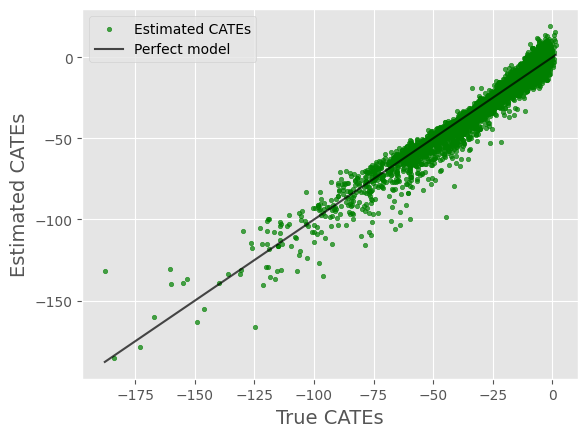

In [294]:
cate_true_vs_estimated_plot(true_cates=df['true_cates'],estimated_cates=df['cate_predictions'])

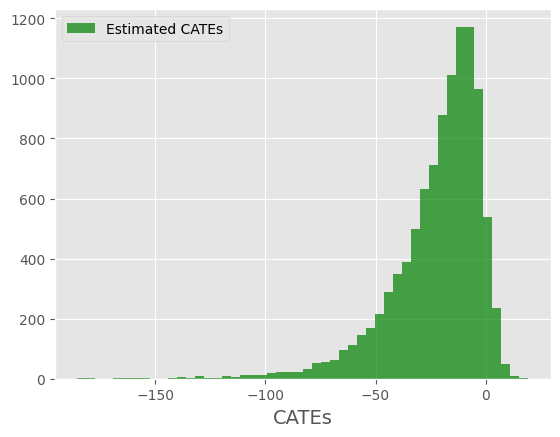

In [295]:
cate_histogram_plot(estimated_cates=df['cate_predictions'])

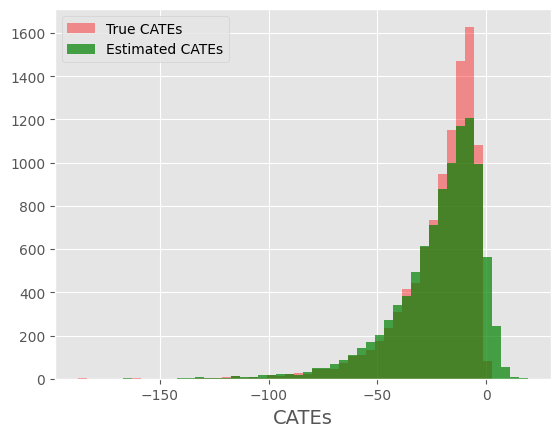

In [296]:
cate_histogram_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'])

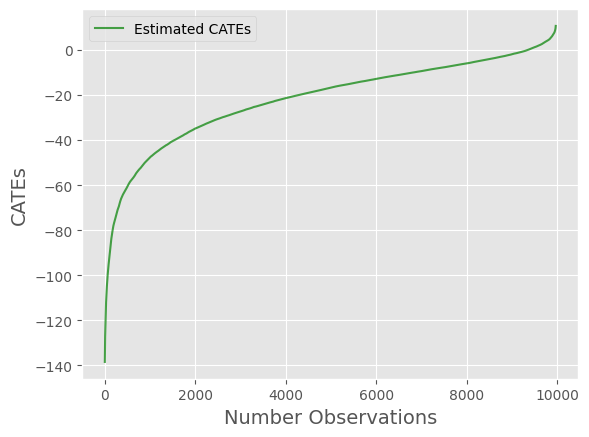

In [297]:
cate_line_plot(estimated_cates=df['cate_predictions'],window=30)

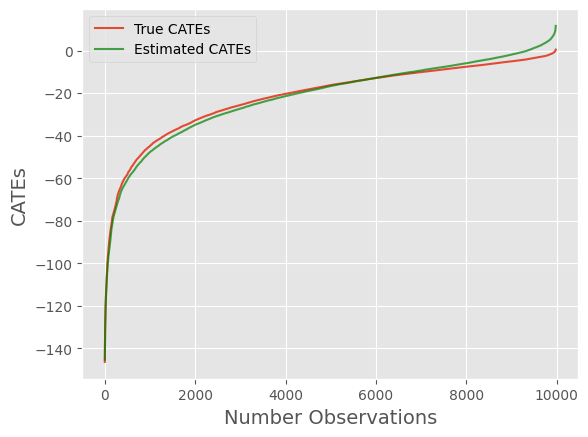

In [298]:
cate_line_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'],window=20)